In [1]:
# @title Import Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
from collections import defaultdict

from sklearn.model_selection import KFold, cross_validate, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost

import matplotlib.dates as mdates
from datetime import timedelta
from dateutil.relativedelta import relativedelta

import shap


In [2]:
# @title Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# drive_data_path = "/content/drive/Shareddrives/Ishango/Programs/AIMS_MSc_Theses_Supervision/AIWP/Project26_MLStacking/data/oliver/"
# df = pd.read_pickle(drive_data_path + "era5_ml_setup_500geopotential_32x64_2020.pkl")
# data_path = "/content/drive/MyDrive/_shared_drive_shortcut/MastersProject/Data/"

# data_path = "/content/drive/MyDrive/_shared/MastersProject/Data/"
# data_plot_path = "/content/drive/MyDrive/_shared/MastersProject/Plots/"

data_path="/content/drive/MyDrive/MastersProject/Data/"
data_plot_path="/content/drive/MyDrive/MastersProject/Plots/"

# data_path="/content/drive/MyDrive/_shared_drive_shortcut/MastersProject/Data/"
# data_plot_path="/content/drive/MyDrive/_shared_drive_shortcut/MastersProject/Plots/"


In [4]:
# @title Load forecasts & ERA5 truth

df =pd.read_pickle(data_path+"era5_ml_setup_500geopotential_32x64_2020.pkl")

lead_times=[48, 72, 96, 120, 144, 168, 192, 216, 240]


for lead_time in lead_times:
    print(lead_time)
    df_aiwp = pd.read_pickle(data_path + f"aiwp_ml_setup_500geopotential_32x64_2020_leadtime{lead_time}.pkl").drop(columns=["area_weight","keisler"])
    df_aiwp = df_aiwp.rename(columns={col: col + "_lt" + str(lead_time) for col in df_aiwp.columns if col not in ["time", "longitude", "latitude"]})
    if lead_time == 48:
      df_aiwp_full = df_aiwp
    else:
      df_aiwp_full = df_aiwp_full.merge(df_aiwp, on=["time", "longitude", "latitude"], how="outer")

print(f"Shape of df :{df.shape}")
print(f"Shape of df_aiwp_full :{df_aiwp_full.shape}")



48
72
96
120
144
168
192
216
240
Shape of df :(1556480, 5)
Shape of df_aiwp_full :(1531904, 39)


In [5]:
# @title Merge ERA5 and Forecasts Across all lead times
full_df = df.merge(df_aiwp_full, on=["time", "longitude", "latitude"], how="outer")
print(full_df.shape)
full_df.head()


(1556480, 41)


,time,longitude,latitude,era5,area_weight,graphcast_lt48,pangu_lt48,neuralgcm_lt48,ifshres_lt48,graphcast_lt72,...,neuralgcm_lt192,ifshres_lt192,graphcast_lt216,pangu_lt216,neuralgcm_lt216,ifshres_lt216,graphcast_lt240,pangu_lt240,neuralgcm_lt240,ifshres_lt240
0,2020-01-01,0.0,-87.1875,49846.941406,0.049068,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,0.0,-81.5625,50196.523438,0.146730,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,0.0,-75.9375,50391.101562,0.242980,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01,0.0,-70.3125,49667.398438,0.336890,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01,0.0,-64.6875,49277.945312,0.427555,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# @title Filter for subset of data for each lead time

def data_per_lead_time(df,lead_time):
  valid_time_lower = df['time'][0]+timedelta(days=int(lead_time/24))
  valid_time_upper = valid_time_lower + relativedelta(years=1)
  df_filtered = df[(df['time'] > valid_time_lower) & (df['time'] < valid_time_upper)]
  return df_filtered[['time','latitude','longitude',"era5","area_weight",
                      f'graphcast_lt{lead_time}',
                      f'pangu_lt{lead_time}',
                      f'neuralgcm_lt{lead_time}',
                      f'ifshres_lt{lead_time}'
                      ]]


In [7]:
for lead_time in lead_times:
  print(lead_time)
  print(data_per_lead_time(full_df,lead_time).isna().sum())

48
time              0
latitude          0
longitude         0
era5              0
area_weight       0
graphcast_lt48    0
pangu_lt48        0
neuralgcm_lt48    0
ifshres_lt48      0
dtype: int64
72
time              0
latitude          0
longitude         0
era5              0
area_weight       0
graphcast_lt72    0
pangu_lt72        0
neuralgcm_lt72    0
ifshres_lt72      0
dtype: int64
96
time              0
latitude          0
longitude         0
era5              0
area_weight       0
graphcast_lt96    0
pangu_lt96        0
neuralgcm_lt96    0
ifshres_lt96      0
dtype: int64
120
time               0
latitude           0
longitude          0
era5               0
area_weight        0
graphcast_lt120    0
pangu_lt120        0
neuralgcm_lt120    0
ifshres_lt120      0
dtype: int64
144
time               0
latitude           0
longitude          0
era5               0
area_weight        0
graphcast_lt144    0
pangu_lt144        0
neuralgcm_lt144    0
ifshres_lt144      0
dtype: int64


In [8]:
# @title Plot the train-test splits for each Fold

def cross_validation_plot(df, cv, lead_time):
  # Extract datetime info using the filtered df
  time_index = df["time"].reset_index(drop=True)

  # Store train/test index lists
  train_indices_list = []
  test_indices_list = []
  for train_index, test_index in cv.split(X):
      train_indices_list.append(train_index)
      test_indices_list.append(test_index)

  # Create the plot
  plt.rcParams['axes.titlesize'] = 16
  plt.rcParams['axes.labelsize'] = 14
  plt.rcParams['xtick.labelsize'] = 12
  plt.rcParams['ytick.labelsize'] = 12
  fig, ax = plt.subplots(figsize=(12, 10))

  # Plot each fold
  for i in range(10):
      # Convert indices to datetime for x-axis
      train_times = time_index.iloc[train_indices_list[i]]
      test_times = time_index.iloc[test_indices_list[i]]

      ax.plot(train_times, [i + 1] * len(train_times), 'bo', label='Train' if i == 0 else "", markersize=5)
      ax.plot(test_times, [i + 1] * len(test_times), 'ro', label='Test' if i == 0 else "", markersize=5)
      ax.axhline(y=i + 1.5, color='lightgray', linestyle='--')

  # Format x-axis as months
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

  # Labels and title
  ax.set_xlabel('Month')
  ax.set_ylabel('Fold')
  ax.set_yticks(range(1, 11))
  ax.set_yticklabels([f'Fold {i+1}' for i in range(10)])
  # ax.set_title(f'Training, Gap and Testing Windows Across 10 Folds for {lead_time} hours lead time.')
  ax.legend(loc='upper right')

  # Improve layout and save
  plt.tight_layout()
  # plt.savefig(data_plot_path + f'Training_Testing_Folds_By_Month_{lead_time}.pdf',
  #             dpi=300, bbox_inches="tight")

  plt.show()


In [9]:
# @title RMSE Comparison for each model and fold

def train_and_evaluate(xgb, cv,X,y, area_weight,lead_time):
  # Create a dictionary to store the results for each fold
  results = {}
  shapley_values = {}

  for fold, (train_index, test_index) in enumerate(cv.split(X)):
      print(f"Fold {fold+1}:")
      fold_results = {}

      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      xgb.fit(X_train, y_train, sample_weight=area_weight.iloc[train_index])



      y_pred = xgb.predict(X_test)
      mse = mean_squared_error(y_test, y_pred)
      print(f"  mse: {mse}")

      area_weighted_rmse = np.sqrt(((y_test-y_pred)**2 * area_weight.iloc[test_index]).mean() / area_weight.iloc[test_index].mean())
      print(f"  PiggyCast: area weighted rmse: {area_weighted_rmse}")
      fold_results["PiggyCast"] = area_weighted_rmse

      for model in [f"graphcast_lt{lead_time}",
                    f"pangu_lt{lead_time}",
                    f"neuralgcm_lt{lead_time}",
                    f"ifshres_lt{lead_time}"]:
          area_weighted_rmse = np.sqrt(((y_test-X_test[model])**2 * area_weight.iloc[test_index]).mean() / area_weight.iloc[test_index].mean())
          print(f"  {model.split('_')[0]}: area weighted rmse: {area_weighted_rmse}")
          fold_results[model.split('_')[0]] = area_weighted_rmse

      results[fold+1] = fold_results

      explainer = shap.TreeExplainer(model=xgb)
      shapley_values_fold = explainer(X_train)
      shapley_values[fold+1] = shapley_values_fold


  return results, shapley_values



In [13]:
# @title Plot RMSE per fold and Model
def rmse_per_fold_plot(results, lead_time):
  plt.rcParams['axes.titlesize'] = 16
  plt.rcParams['axes.labelsize'] = 14
  plt.rcParams['xtick.labelsize'] = 14
  plt.rcParams['ytick.labelsize'] = 14
  plt.rcParams['legend.fontsize'] = 14
  fig, ax = plt.subplots(figsize=(8, 6))

  for model in results[1].keys():  # Iterate through all model names
      rmse_values = [results[fold][model] for fold in results]
      fold_numbers = list(results.keys())
      ax.plot(fold_numbers, rmse_values, label=model, marker='o')

  ax.set_xlabel('Fold')
  ax.set_ylabel('RMSE (metres)')
  # ax.set_title(f'RMSE for Each Fold and Model at {lead_time} hours lead time.')
  ax.legend(loc="upper right")
  plt.grid(True)
  # plt.savefig(data_plot_path + f'RMSE_for_Each_Fold_and_Model_{lead_time}.pdf', dpi=300, bbox_inches="tight")
  plt.savefig(f'RMSE_for_Each_Fold_and_Model_{lead_time}.pdf', dpi=300, bbox_inches="tight")


  plt.show()


Lead time: 48
Shape of x :(1497088, 6)
Shape of y : (1497088,)
Fold 1:
  mse: 15209.0927734375
  PiggyCast: area weighted rmse: 76.76277746972184
  graphcast: area weighted rmse: 72.89521727913798
  pangu: area weighted rmse: 81.53557879205798
  neuralgcm: area weighted rmse: 61.32865112702906
  ifshres: area weighted rmse: 77.69317822238818
Fold 2:
  mse: 9210.8720703125
  PiggyCast: area weighted rmse: 66.86750469041097
  graphcast: area weighted rmse: 70.89595346008002
  pangu: area weighted rmse: 80.0969255422813
  neuralgcm: area weighted rmse: 62.04284877201307
  ifshres: area weighted rmse: 76.40121126092066
Fold 3:
  mse: 7203.16845703125
  PiggyCast: area weighted rmse: 64.48324208575639
  graphcast: area weighted rmse: 70.5749420055696
  pangu: area weighted rmse: 74.76480428843476
  neuralgcm: area weighted rmse: 61.50660557160111
  ifshres: area weighted rmse: 74.98039911101573
Fold 4:
  mse: 10929.08203125
  PiggyCast: area weighted rmse: 74.77433859172058
  graphcast: are

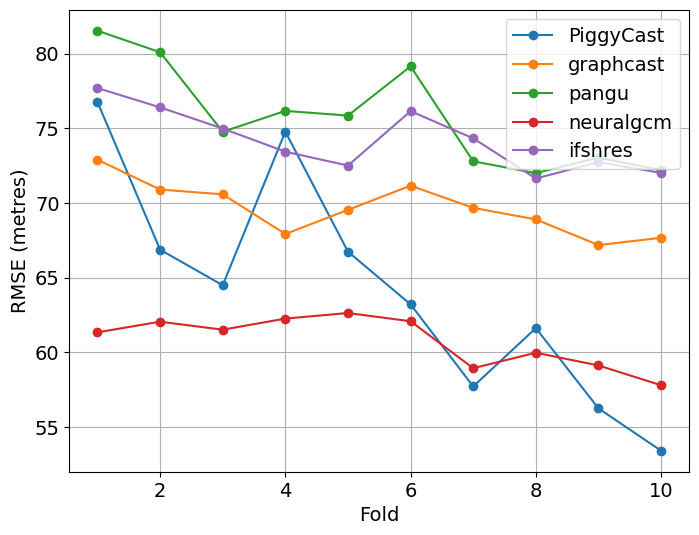

Lead time: 72
Shape of x :(1497088, 6)
Shape of y : (1497088,)
Fold 1:
  mse: 25877.22265625
  PiggyCast: area weighted rmse: 115.03192565675418
  graphcast: area weighted rmse: 122.85387708812033
  pangu: area weighted rmse: 135.08533958019098
  neuralgcm: area weighted rmse: 108.71967205337731
  ifshres: area weighted rmse: 131.52903243672063
Fold 2:
  mse: 20881.48046875
  PiggyCast: area weighted rmse: 107.9994745127202
  graphcast: area weighted rmse: 121.55502280923785
  pangu: area weighted rmse: 134.301915560045
  neuralgcm: area weighted rmse: 110.53258883735597
  ifshres: area weighted rmse: 130.6921929942073
Fold 3:
  mse: 16885.568359375
  PiggyCast: area weighted rmse: 102.35013330448703
  graphcast: area weighted rmse: 115.12777744553853
  pangu: area weighted rmse: 124.96075061143948
  neuralgcm: area weighted rmse: 106.80123183454789
  ifshres: area weighted rmse: 126.64768147865912
Fold 4:
  mse: 21867.5078125
  PiggyCast: area weighted rmse: 110.57140621198165
  graph

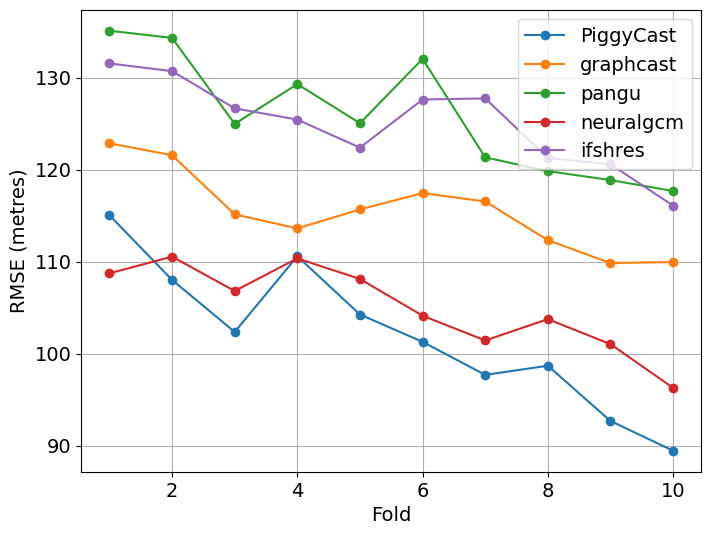

In [14]:
# @title Training and Evaluation Loop

# Initialize xgb regressor
xgb = xgboost.XGBRegressor(random_state=42, device="cuda")

# Calculate Cross-Validation using 10 folds
cv_timeseries = TimeSeriesSplit(n_splits=10, max_train_size=32 * 64 * 2 * 60,
                                test_size= 32 * 64 * 2 * 30, gap=32 * 64 * 2 * 5)

# Lead Times
# lead_times=[48, 72, 96, 120, 144, 168, 192, 216, 240]
lead_times=[48, 72]

nested_scores = {} # Nested scores for each lead time
rmse_results = {} # rmse results for each lead time, models
shapley_values_results = {} # Shapley values for each lead time

for lead_time in lead_times:
  print(f"Lead time: {lead_time}")

  df_filtered = data_per_lead_time(full_df,lead_time)

  X = df_filtered[[f"graphcast_lt{lead_time}", f"pangu_lt{lead_time}",
                   f"neuralgcm_lt{lead_time}",
                   f"ifshres_lt{lead_time}", "longitude", "latitude"]]
  y = df_filtered["era5"]
  area_weight = df_filtered["area_weight"]

  print(f"Shape of x :{X.shape}")
  print(f"Shape of y : {y.shape}")

  # Nested Scores
  nested_score = cross_validate(xgb, X=X, y=y, cv=cv_timeseries,
                              scoring=('neg_mean_squared_error', 'r2'),
                              params={'sample_weight': area_weight}
                              )
  nested_scores[lead_time] = nested_score

  # Cross validation plot
  # cross_validation_plot(df_filtered, cv_timeseries, lead_time)

  # RMSE and SHAPley Values
  rmse_result, shapley_values = train_and_evaluate(xgb, cv_timeseries,X,y, area_weight, lead_time)
  rmse_results[lead_time] = rmse_result
  shapley_values_results[lead_time]= shapley_values

  # RMSE plots per model
  rmse_per_fold_plot(rmse_result, lead_time)



In [ ]:
# @title Save RMSE Results, Shapley Values Model
joblib.dump(rmse_results, data_path + "rmse_results.pkl")
joblib.dump(xgb, data_path+ 'xgb_model.pkl')
joblib.dump(shapley_values_results, data_path+"shapley_values_results.pkl")

['/content/drive/MyDrive/_shared_drive_shortcut/MastersProject/Data/shapley_values_results.pkl']

In [ ]:
# @title Load RMSE Results, Shapley Values and Model
rmse_results = joblib.load(data_path + "rmse_results.pkl")
xgb = joblib.load(data_path+ 'xgb_model.pkl')
shapley_values_results = joblib.load(data_path+"shapley_values_results.pkl")

In [ ]:
# @title Calculate RMSE Mean of Model per Lead time

def rmse_mean_per_lead_time_and_model(rmse_results):
  # average scores per lead time and model
  average_scores = {}

  for lead_time, folds in rmse_results.items():
      model_scores = defaultdict(list)

      # collect values per model
      for fold_scores in folds.values():
          for model, value in fold_scores.items():
              model_scores[model].append(value)

      # average for each model
      average_scores[lead_time] = {model: float(np.mean(scores)) for model, scores in model_scores.items()}
  return average_scores



In [ ]:
# print nicely
from pprint import pprint
average_scores = rmse_mean_per_lead_time_and_model(rmse_results)
pprint(average_scores)

{48: {'PiggyCast': 64.1775584914425,
      'graphcast': 69.63800331707469,
      'ifshres': 74.18631782545808,
      'neuralgcm': 60.76147382469113,
      'pangu': 75.75723848328518},
 72: {'PiggyCast': 101.99432560939412,
      'graphcast': 115.48760779732575,
      'ifshres': 124.99237446580557,
      'neuralgcm': 105.10781897069894,
      'pangu': 125.83565063238966},
 96: {'PiggyCast': 159.17793967232666,
      'graphcast': 179.66465739456424,
      'ifshres': 197.23465344920965,
      'neuralgcm': 169.5452751589802,
      'pangu': 196.21785805711082},
 120: {'PiggyCast': 235.87207436116574,
       'graphcast': 263.02001145458746,
       'ifshres': 288.772845868478,
       'neuralgcm': 252.5258417125255,
       'pangu': 285.7960725176161},
 144: {'PiggyCast': 324.301274983238,
       'graphcast': 359.0340948409652,
       'ifshres': 392.49669635762825,
       'neuralgcm': 347.88904311399256,
       'pangu': 387.42279441340935},
 168: {'PiggyCast': 418.30397698636364,
       'graphc

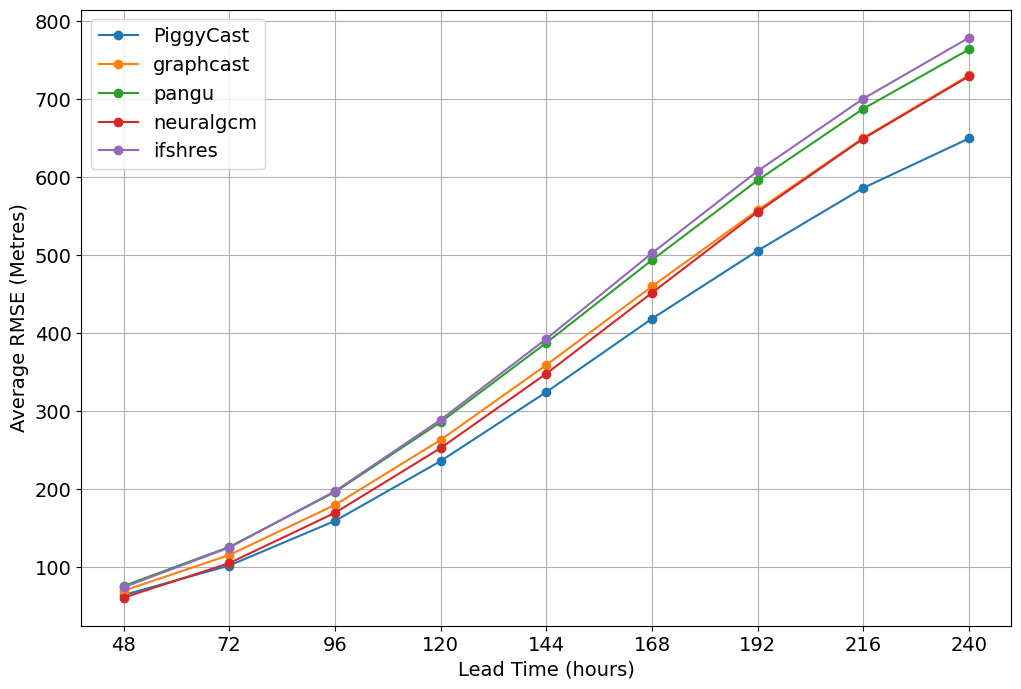

In [ ]:
# @title Plot RMSE per lead time and Model
def rmse_per_lead_time_plot_all_lead_times(average_scores):
  models = list(average_scores[next(iter(average_scores))].keys())

  fig, ax = plt.subplots(figsize=(12, 8))

  for model in models:
      avg_rmse_per_lead_time = []
      lead_times = []

      for lead_time, lead_time_average in average_scores.items():
          avg_rmse_per_lead_time.append(lead_time_average[model])
          lead_times.append(lead_time)

      ax.plot(lead_times, avg_rmse_per_lead_time, label=model, marker='o')

  ax.set_xlabel("Lead Time (hours)")
  ax.set_ylabel("Average RMSE (Metres)")
  # ax.set_title("Average RMSE vs Lead Time per Model")
  ax.set_xticks(range(min(lead_times), max(lead_times)+1, 24))  # Set interval of 24 hours
  ax.legend(loc="upper left")
  plt.rcParams['axes.titlesize'] = 16
  plt.rcParams['axes.labelsize'] = 14
  plt.rcParams['xtick.labelsize'] = 14
  plt.rcParams['ytick.labelsize'] = 14
  plt.rcParams['legend.fontsize'] = 14
  plt.grid(True)
  plt.savefig(data_plot_path + 'Average_RMSE_vs_Lead_Time_per_Model.pdf', dpi=300, bbox_inches="tight")
  plt.show()

rmse_per_lead_time_plot_all_lead_times(average_scores)


In [ ]:
# @title Plot % Improvement over IFS HRES per fold and model
def plot_improvement_over_ifshres(results, lead_time):
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    fig, ax = plt.subplots(figsize=(8, 6))

    for model in results[1].keys():
        if model == 'ifshres':
            continue  # Skip baseline itself

        improvement_values = []
        for fold in results:
            rmse_ifshres = results[fold]['ifshres']
            rmse_model = results[fold][model]
            improvement = ((rmse_ifshres - rmse_model) / rmse_ifshres) * 100
            improvement_values.append(improvement)

        ax.plot(list(results.keys()), improvement_values, label=model, marker='o')

    ax.set_xlabel('Fold')
    ax.set_ylabel('% Improvement over IFS HRES')
    # ax.set_title(f'RMSE % Improvement over IFS HRES at {lead_time} hours lead time.')
    ax.legend(loc="lower center")
    plt.grid(True)
    # plt.savefig(data_plot_path + f'RMSE_Percentage_Improvement over IFS HRES at {lead_time} hours lead time.pdf', dpi=300, bbox_inches="tight")

    plt.show()




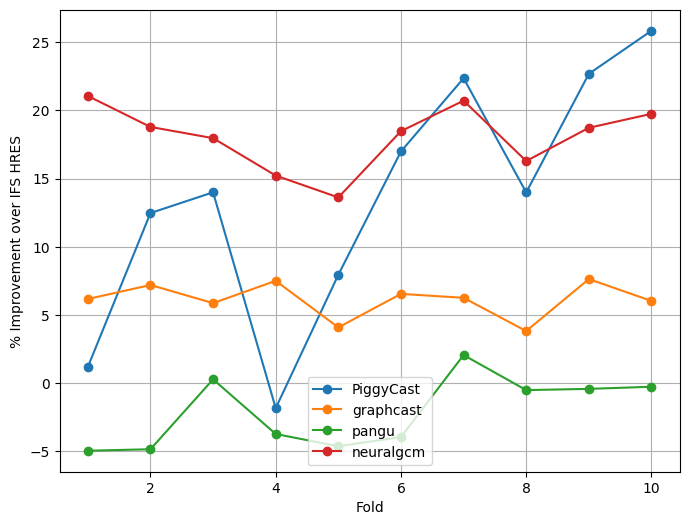

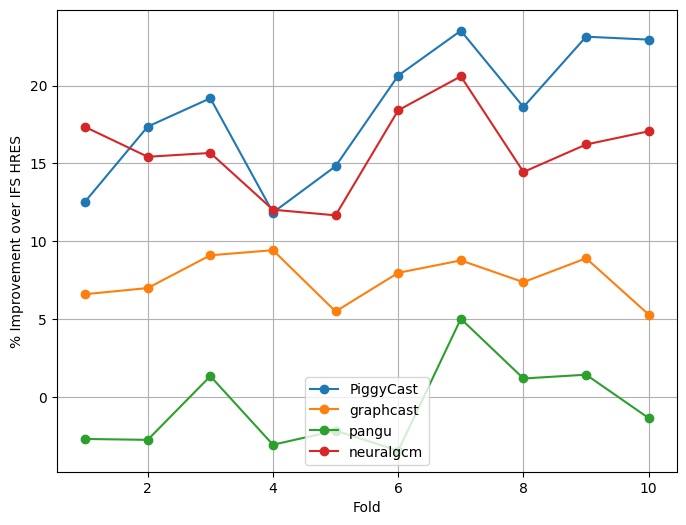

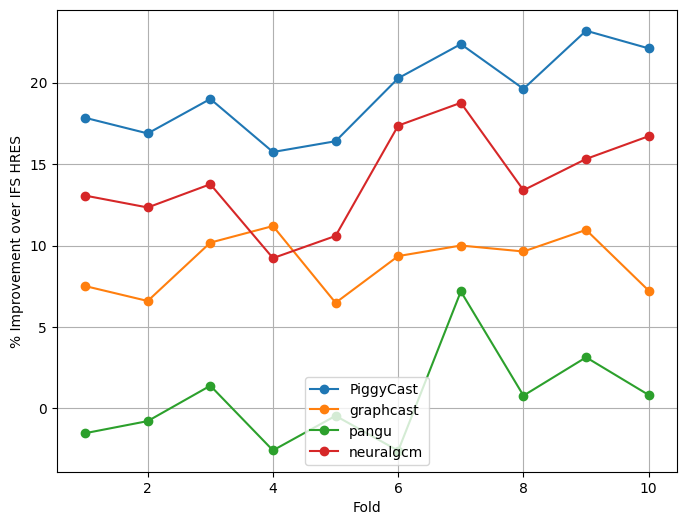

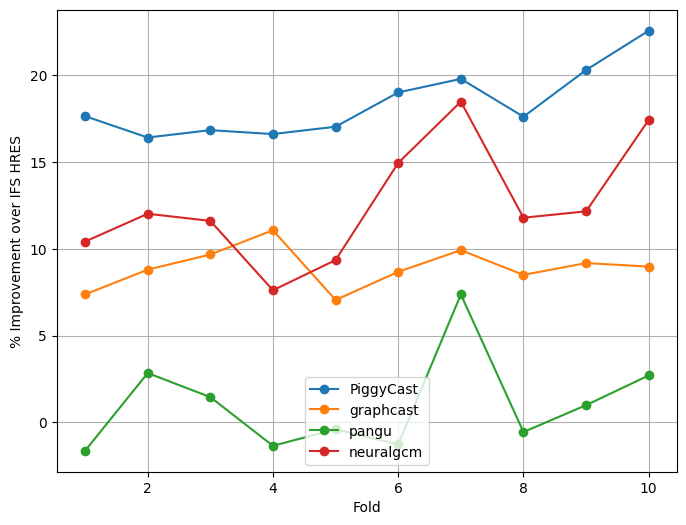

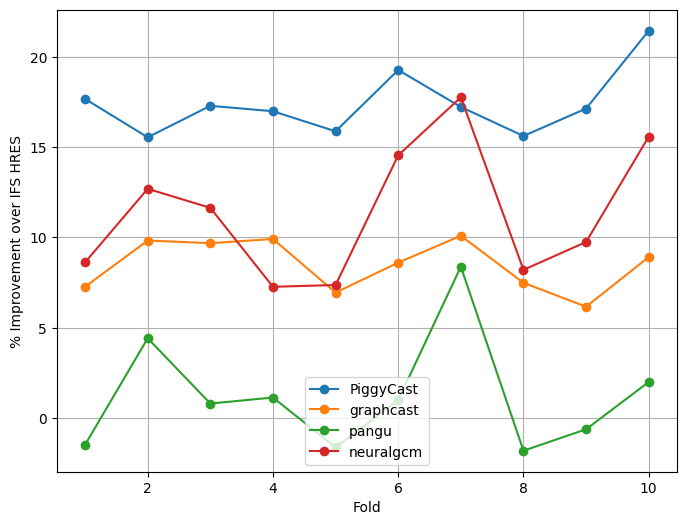

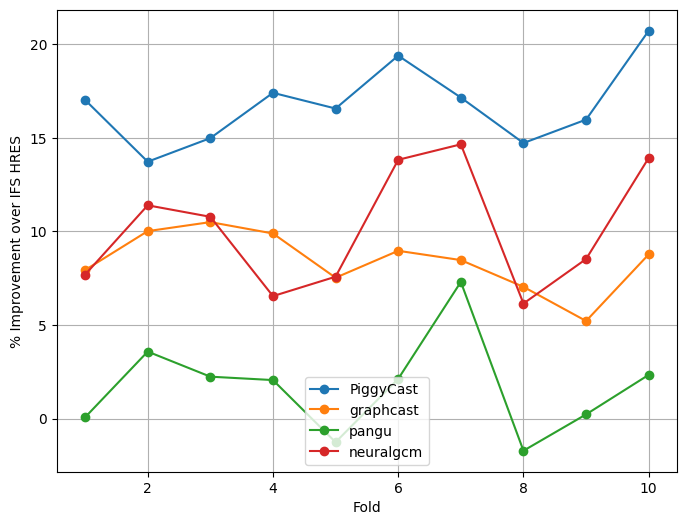

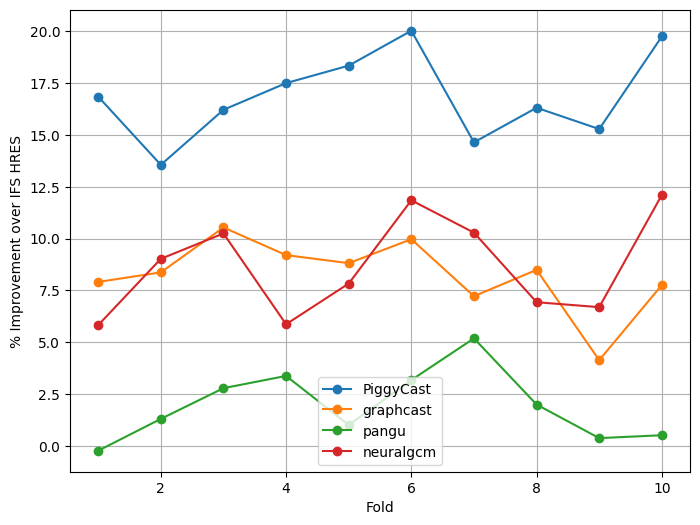

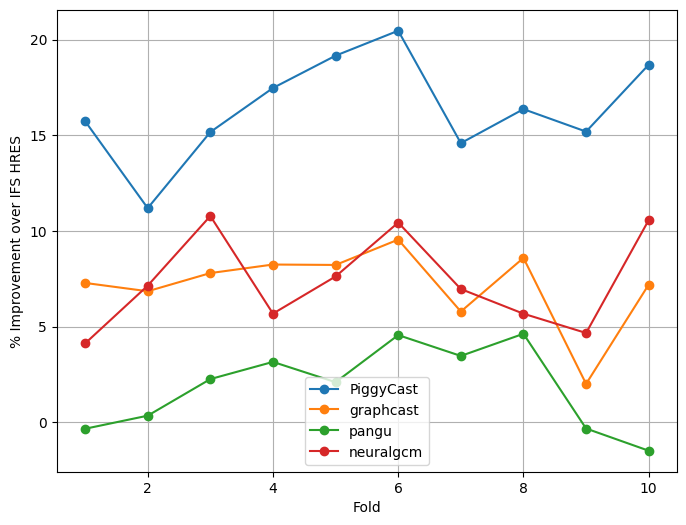

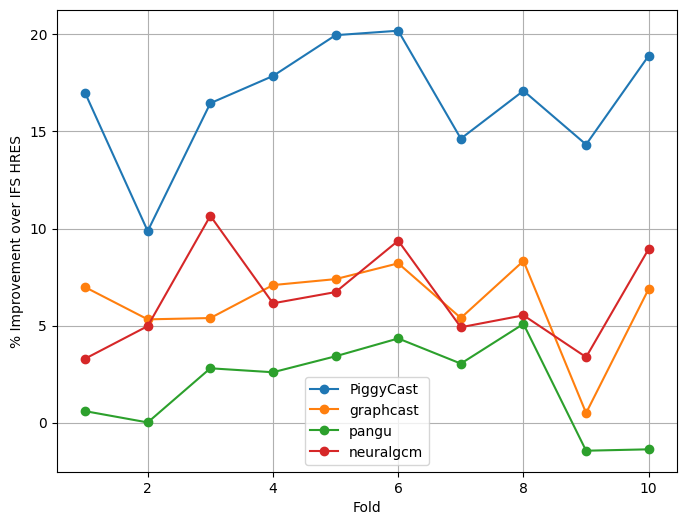

In [ ]:
for lead_time in lead_times:
  plot_improvement_over_ifshres(rmse_results[lead_time], lead_time)

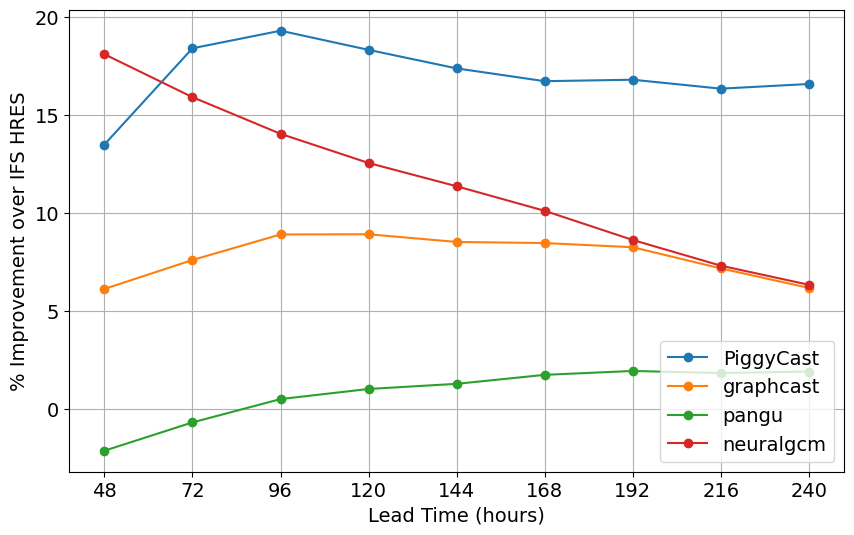

In [ ]:
# @title Plot % Improvement over IFS HRES per lead time and model
def percent_improvement_over_ifshres_per_lead_time(average_scores):
  models = list(average_scores[next(iter(average_scores))].keys())
  plt.rcParams['axes.titlesize'] = 12
  plt.rcParams['axes.labelsize'] = 14
  plt.rcParams['xtick.labelsize'] = 14
  plt.rcParams['ytick.labelsize'] = 14
  plt.rcParams['legend.fontsize'] = 14

  fig, ax = plt.subplots(figsize=(10, 6))

  for model in models:
      if model == 'ifshres':
          continue  # Skip baseline itself

      percentage_improvement = []
      lead_times = []

      for lead_time, lead_time_average in average_scores.items():
          rmse_ifshres = lead_time_average['ifshres']
          rmse_model = lead_time_average[model]
          improvement = ((rmse_ifshres - rmse_model) / rmse_ifshres) * 100
          percentage_improvement.append(improvement)
          lead_times.append(lead_time)

      ax.plot(lead_times, percentage_improvement, label=model, marker='o')

  ax.set_xlabel("Lead Time (hours)")
  ax.set_ylabel("% Improvement over IFS HRES")
  # ax.set_title("RMSE % Improvement over IFS HRES per Lead Time per Model")
  ax.set_xticks(range(min(lead_times), max(lead_times)+1, 24))
  ax.legend(loc="lower right")
  plt.grid(True)
  plt.savefig(data_plot_path + 'RMSE Percentage Improvement over IFS HRES per Lead Time per Model.pdf', dpi=300, bbox_inches="tight")
  plt.show()

percent_improvement_over_ifshres_per_lead_time(average_scores)


In [ ]:
# print nicely
from pprint import pprint

models = list(average_scores[next(iter(average_scores))].keys())
percentage_improvement = {}

for lead_time, lead_time_average in average_scores.items():
  model_improvement= {}
  for model in models:
    if model == 'ifshres':
      continue

    rmse_ifshres = lead_time_average['ifshres']
    rmse_model = lead_time_average[model]
    improvement = ((rmse_ifshres - rmse_model) / rmse_ifshres) * 100
    model_improvement[model]= improvement
  percentage_improvement[lead_time] =model_improvement

pprint(percentage_improvement)

{48: {'PiggyCast': 13.491381736405486,
      'graphcast': 6.130934438725529,
      'neuralgcm': 18.096118521952064,
      'pangu': -2.1175342082930806},
 72: {'PiggyCast': 18.39956153701446,
      'graphcast': 7.604277228192075,
      'neuralgcm': 15.908614889579912,
      'pangu': -0.6746620905380006},
 96: {'PiggyCast': 19.295145711644967,
      'graphcast': 8.908168898002446,
      'neuralgcm': 14.038799879231068,
      'pangu': 0.5155257325816052},
 120: {'PiggyCast': 18.319164098762243,
       'graphcast': 8.918024939789419,
       'neuralgcm': 12.552081913013813,
       'pangu': 1.03083561818609},
 144: {'PiggyCast': 17.37477589168118,
       'graphcast': 8.525575330237471,
       'neuralgcm': 11.365102855029097,
       'pangu': 1.2927247519035816},
 168: {'PiggyCast': 16.722221037463207,
       'graphcast': 8.469785000408267,
       'neuralgcm': 10.112889204121204,
       'pangu': 1.7511527774740359},
 192: {'PiggyCast': 16.79717828217678,
       'graphcast': 8.256969720121319,


In [ ]:
# @title Combined Shapely Values for Feature importance

def combined_shap_explanations_per_lead_time(shap_values_dict):
    # Step 1: Collect all Explanation objects
    all_explanations = list(shap_values_dict.values())  # shap_values is your fold-wise dict

    # Step 2: Concatenate .values, .base_values, .data, etc.
    combined_values = np.concatenate([e.values for e in all_explanations], axis=0)
    combined_base_values = np.concatenate([e.base_values for e in all_explanations], axis=0)
    combined_data = np.concatenate([e.data for e in all_explanations], axis=0)

    # Step 3: Recreate the Explanation object
    combined_explanation = shap.Explanation(
        values=combined_values,
        base_values=combined_base_values,
        data=combined_data,
        feature_names=all_explanations[0].feature_names
    )
    return combined_explanation


Lead_time: 48 


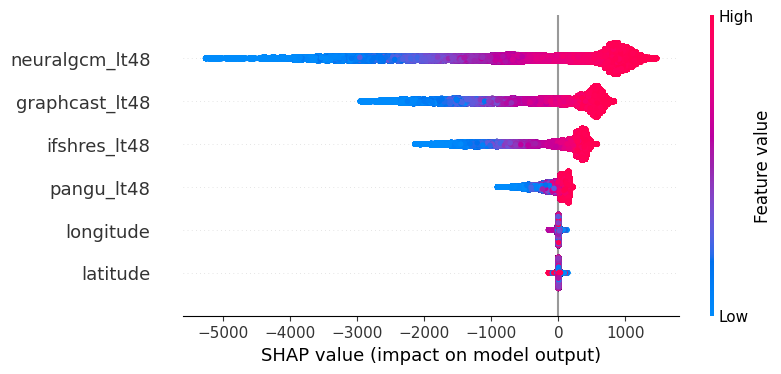

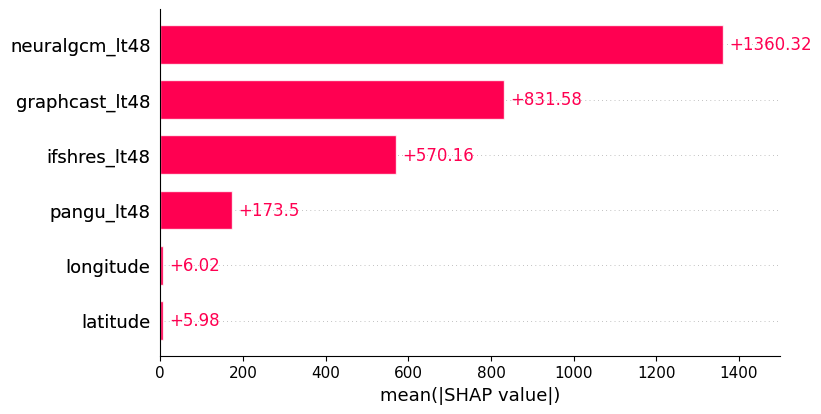

Lead_time: 72 


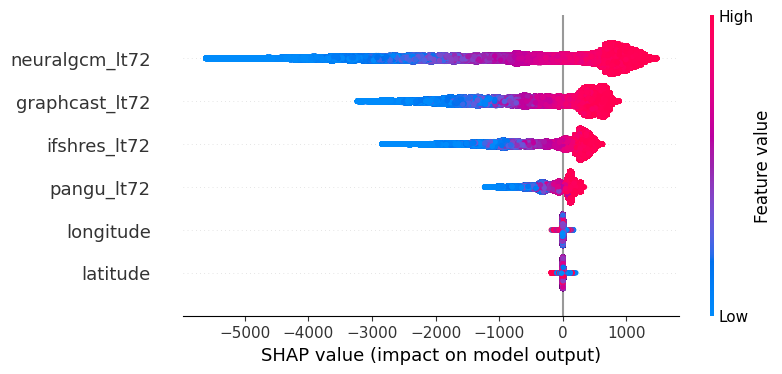

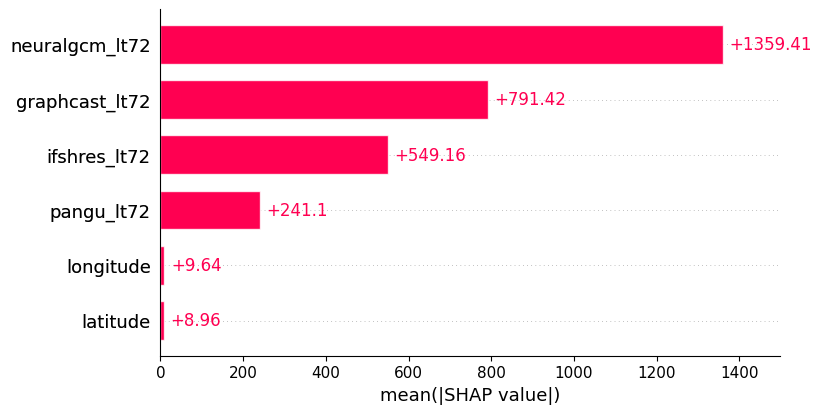

Lead_time: 96 


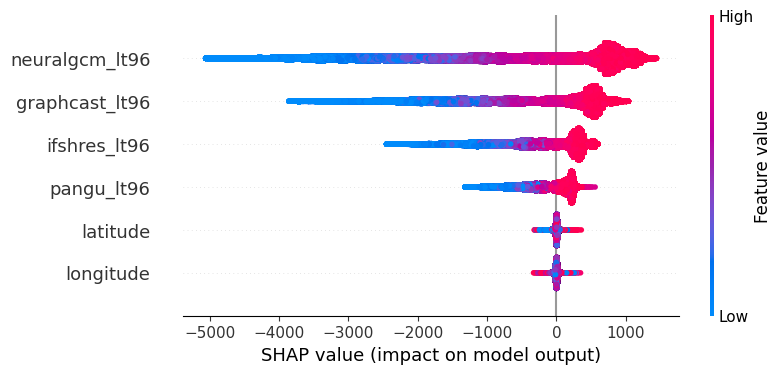

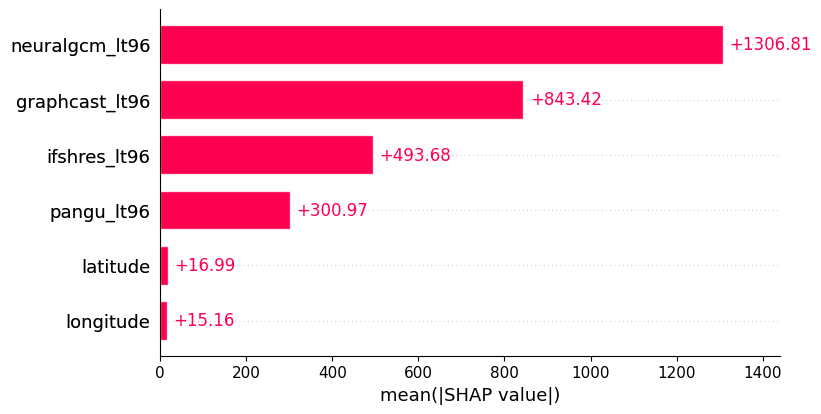

Lead_time: 120 


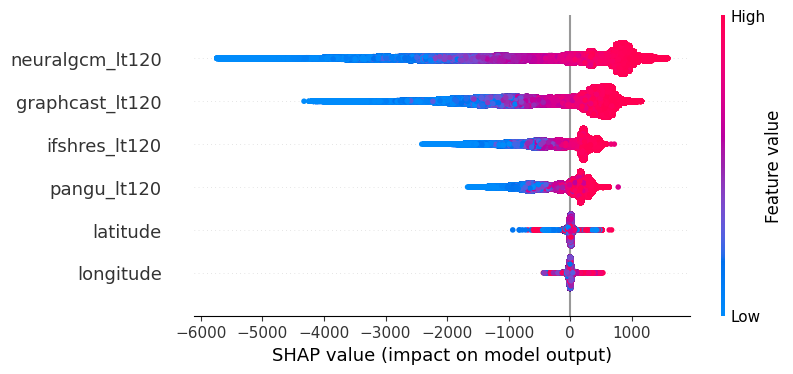

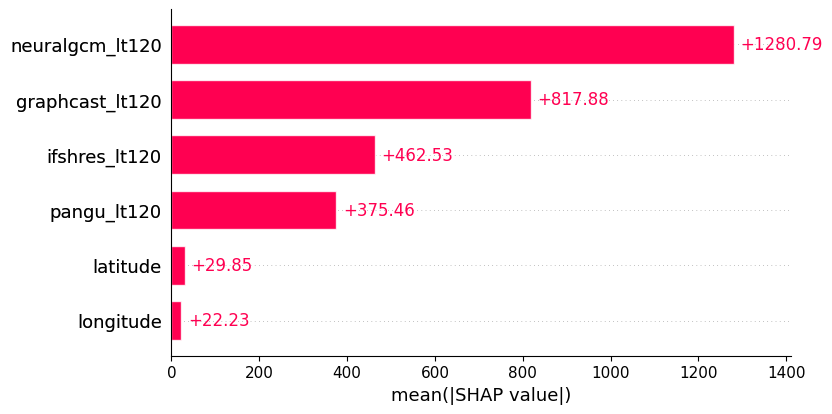

Lead_time: 144 


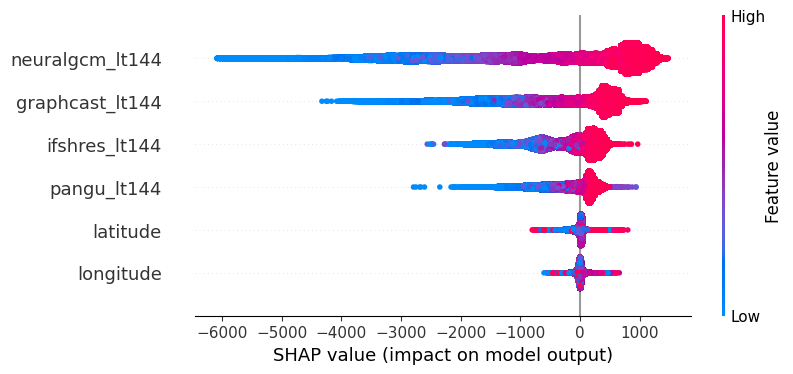

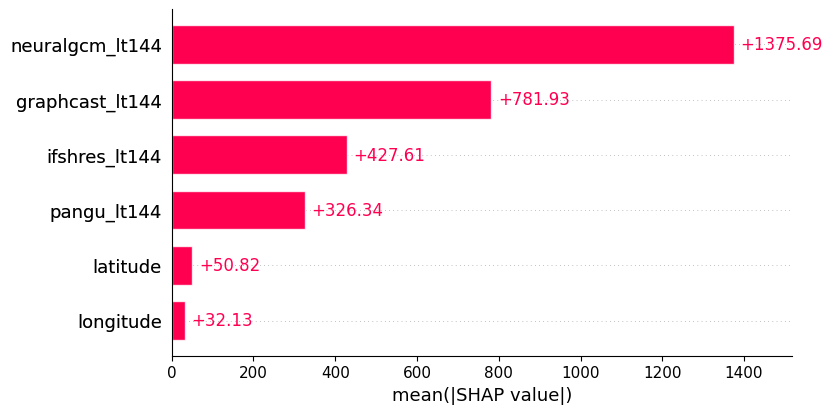

Lead_time: 168 


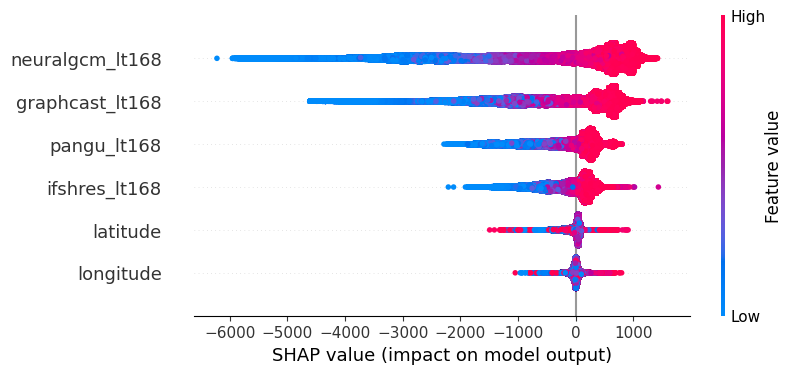

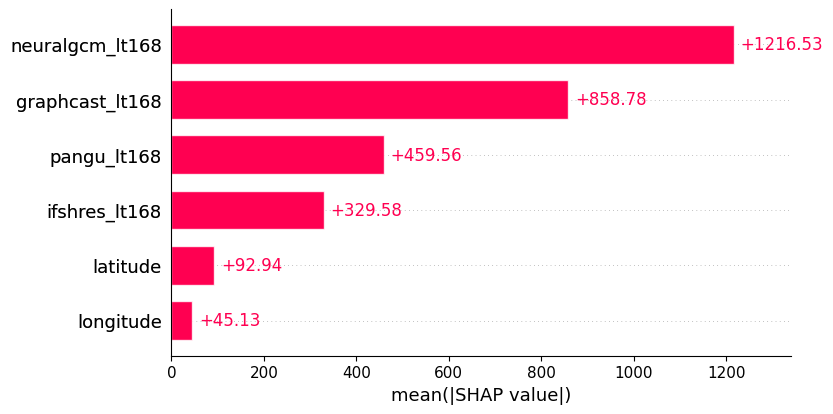

Lead_time: 192 


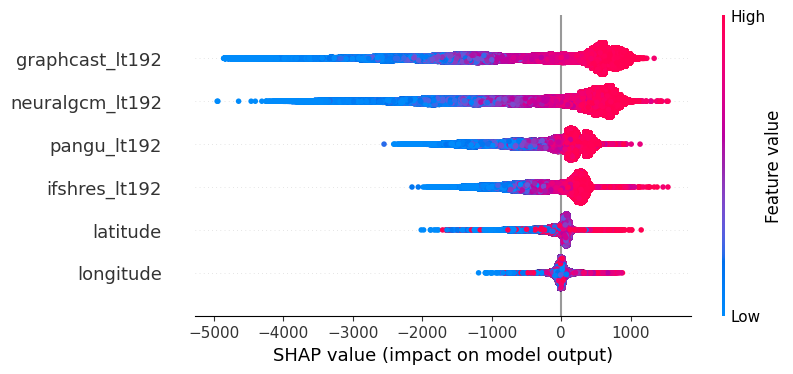

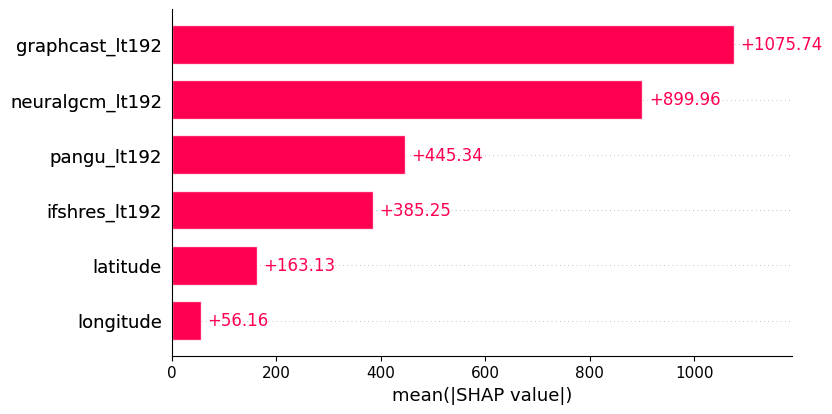

Lead_time: 216 


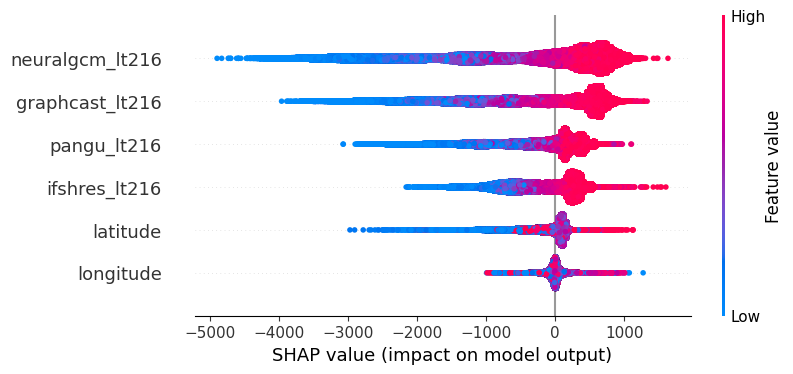

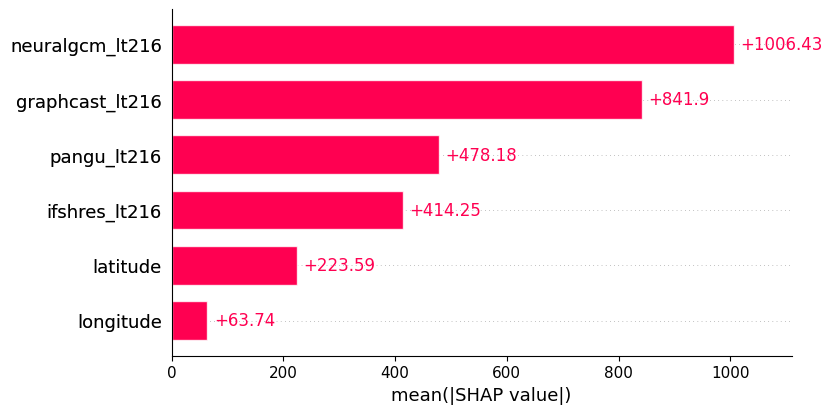

Lead_time: 240 


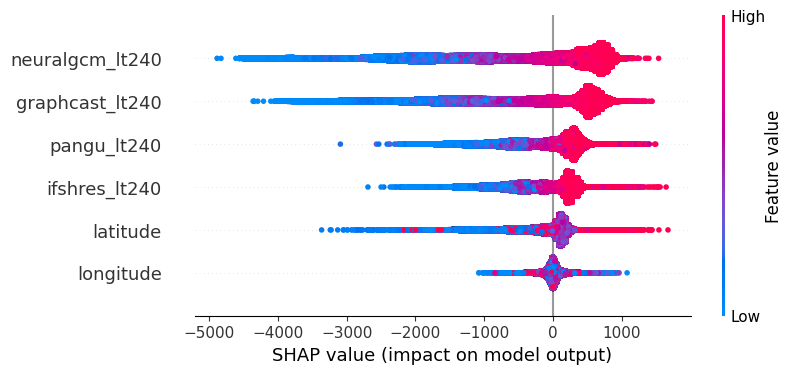

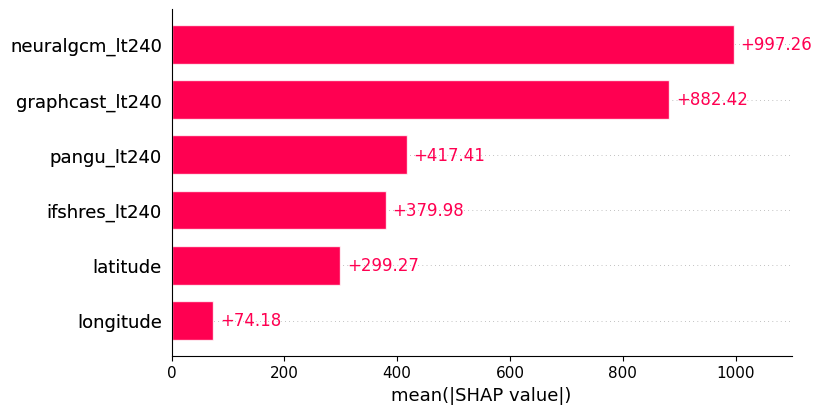

<Figure size 640x480 with 0 Axes>

In [ ]:
for lead_time, shapley_explanations in shapley_values_results.items():
  print(f"Lead_time: {lead_time} ")
  combined_explanation = combined_shap_explanations_per_lead_time(shapley_explanations)
  shap.plots.beeswarm(combined_explanation)
  # plt.savefig(data_plot_path+ f'shap_beeswarm_plot_at_{lead_time}_hr_lead_time.pdf', dpi=300, bbox_inches="tight")
  shap.plots.bar(combined_explanation, max_display=12)
  # plt.savefig(data_plot_path+ f'shap_bar_plot_at_{lead_time}_hr_lead_time.pdf', dpi=300, bbox_inches="tight")
